In [1]:
import pandas as pd
#math operations
import numpy as np
#machine learning
import cv2                     
import os                  
from random import shuffle
from tqdm import tqdm  
import random
#for opening and loading image
from PIL import Image
#for preprocessing
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#Doing One hot encoding as classifier has multiple classes
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from random import shuffle
#For augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#MobileNetV2 model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers
from numpy import loadtxt

import itertools
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

2025-06-15 19:16:45.312296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750015005.504193      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750015005.560957      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


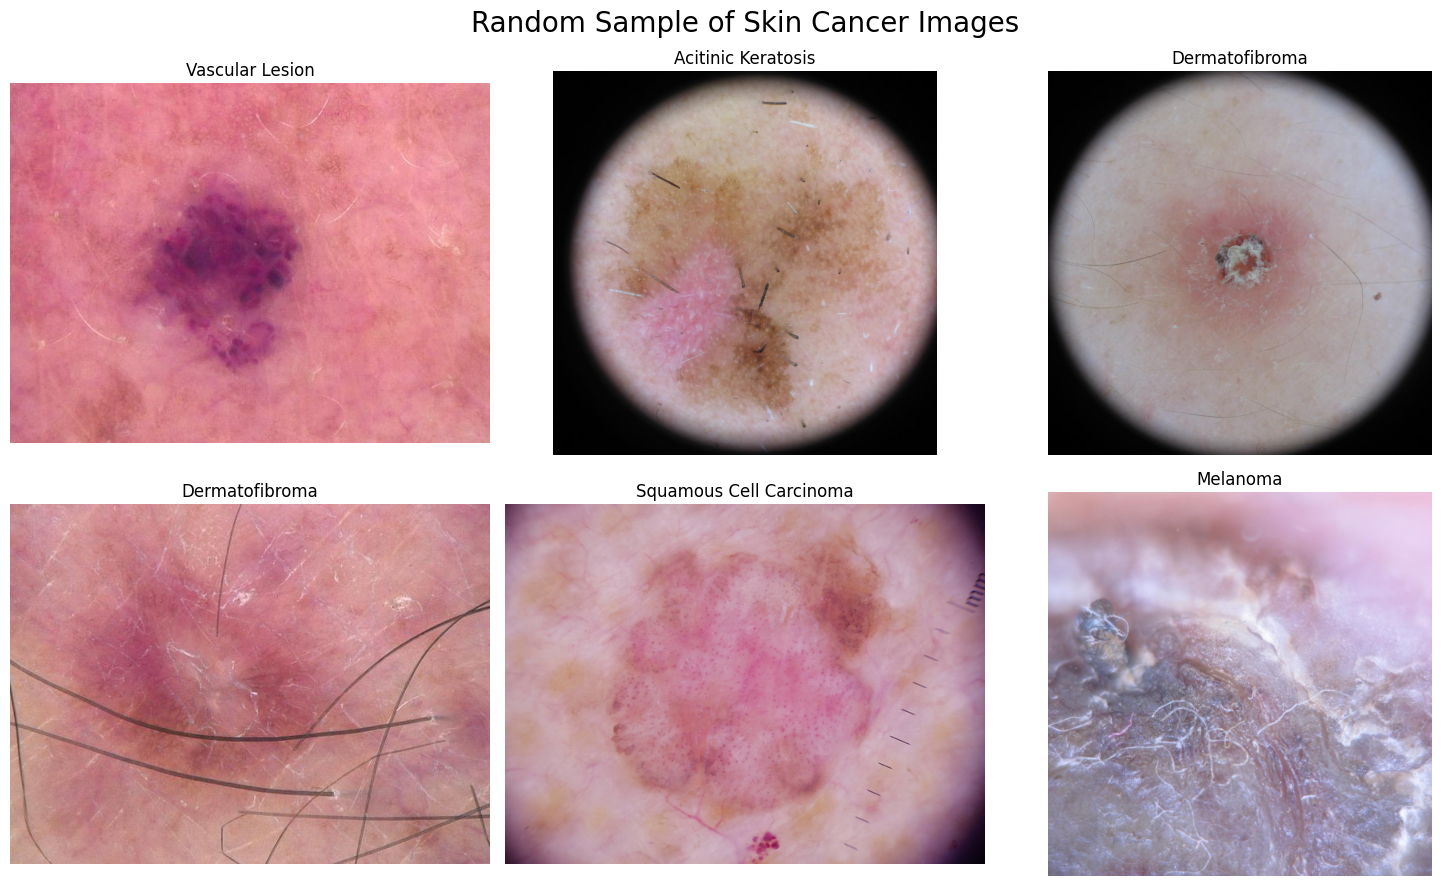

In [2]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# Base directory
base_dir = "/kaggle/input/dataset-skin-cancer/Skin Cancer Dataset"

# Dictionary to hold image paths and labels
image_paths = []

# Load all images from all subfolders
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append((img_path, class_name))

# Shuffle and take 6 random samples
sample_images = random.sample(image_paths, 6)

# Display the images
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
    img_path, label = sample_images[i]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[i // 3, i % 3].imshow(image)
    ax[i // 3, i % 3].axis('off')
    ax[i // 3, i % 3].set_title(label)

fig.suptitle('Random Sample of Skin Cancer Images', fontsize=20)
plt.tight_layout()
plt.show()


In [3]:
import os
import cv2
import numpy as np
from PIL import Image

data = []
labels = []

base_path = "/kaggle/input/dataset-skin-cancer/Skin Cancer Dataset"

# Automatically get class names
class_folders = sorted(os.listdir(base_path))  # ['Melanoma', 'Nevus', ...]

for label, class_name in enumerate(class_folders):
    class_path = os.path.join(base_path, class_name)

    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name} (Label: {label})")

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            image = cv2.imread(img_path)
            if image is None:
                print(f"Skipping unreadable image: {img_name}")
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(image_rgb)
            resized_image = image_pil.resize((224, 224))

            data.append(np.array(resized_image))
            labels.append(label)
        except Exception as e:
            print(f"Error processing image {img_name} in {class_name}: {e}")


Processing class: Acitinic Keratosis (Label: 0)
Processing class: Basal Cell Carcinoma (Label: 1)
Processing class: Dermatofibroma (Label: 2)
Skipping unreadable image: metadata.csv
Processing class: Melanoma (Label: 3)
Processing class: Nevus (Label: 4)
Processing class: Pigmented Benign Keratosis (Label: 5)
Processing class: Seborrheic Keratosis (Label: 6)
Processing class: Squamous Cell Carcinoma (Label: 7)
Processing class: Vascular Lesion (Label: 8)


In [4]:
import os
import cv2
import numpy as np
from PIL import Image

data = []
labels = []

# Base directory where the class folders (e.g., Melanoma, Nevus, etc.) are located
base_path = "/kaggle/input/dataset-skin-cancer/Skin Cancer Dataset"
class_folders = sorted(os.listdir(base_path))  # List all class folders (9 classes)

for label, class_name in enumerate(class_folders):
    class_path = os.path.join(base_path, class_name)  # Removed "train"

    if not os.path.isdir(class_path):
        continue  # Skip files or corrupted entries

    print(f"Resizing images in class: {class_name} (Label: {label})")

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            image = cv2.imread(img_path)
            if image is None:
                continue  # Skip unreadable files

            # Convert BGR to RGB and resize to 224x224
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_pil = Image.fromarray(image_rgb)
            resized_image = image_pil.resize((224, 224))

            data.append(np.array(resized_image))
            labels.append(label)

        except Exception as e:
            print(f"Error with image {img_name} in {class_name}: {e}")


Resizing images in class: Acitinic Keratosis (Label: 0)
Resizing images in class: Basal Cell Carcinoma (Label: 1)
Resizing images in class: Dermatofibroma (Label: 2)
Resizing images in class: Melanoma (Label: 3)
Resizing images in class: Nevus (Label: 4)
Resizing images in class: Pigmented Benign Keratosis (Label: 5)
Resizing images in class: Seborrheic Keratosis (Label: 6)
Resizing images in class: Squamous Cell Carcinoma (Label: 7)
Resizing images in class: Vascular Lesion (Label: 8)


In [5]:
import numpy as np

# Assuming you already have 'data' (list of resized image arrays) and 'labels' (list of labels)
feats = np.array(data)      # Convert list of images to numpy array
labels = np.array(labels)   # Convert list of labels to numpy array

# Save to Kaggle working directory for reuse
np.save("/kaggle/working/feats_train.npy", feats)
np.save("/kaggle/working/labels_train.npy", labels)

print(f"Saved features and labels with shapes: {feats.shape}, {labels.shape}")


Saved features and labels with shapes: (4626, 224, 224, 3), (4626,)


In [6]:
import numpy as np

# Load saved features and labels
feats = np.load("/kaggle/working/feats_train.npy")
labels = np.load("/kaggle/working/labels_train.npy")

print(f"Loaded features shape: {feats.shape}")
print(f"Loaded labels shape: {labels.shape}")


Loaded features shape: (4626, 224, 224, 3)
Loaded labels shape: (4626,)


In [7]:
s = np.arange(feats.shape[0])
np.random.shuffle(s)
feats = feats[s]
labels = labels[s]


In [8]:
num_classes=len(np.unique(labels))
len_data=len(feats)
print(len_data)
print(num_classes)

4626
9


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Assuming 'feats' is your features array and 'labels' is the class label array
# feats shape: (num_samples, height, width, channels)
# labels shape: (num_samples,) - integer class labels

# Split the data using sklearn's train_test_split with shuffling and stratification
x_train, x_test, y_train, y_test = train_test_split(
    feats, labels, test_size=0.20, random_state=42, stratify=labels
)

# Normalize feature data to range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert integer labels to one-hot encoding (9 classes)
y_train = to_categorical(y_train, num_classes=9)
y_test = to_categorical(y_test, num_classes=9)

# Print the shapes to verify correctness
print("x_train shape:", x_train.shape)
print("y_train shape after one-hot:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape after one-hot:", y_test.shape)


x_train shape: (3700, 224, 224, 3)
y_train shape after one-hot: (3700, 9)
x_test shape: (926, 224, 224, 3)
y_test shape after one-hot: (926, 9)


In [10]:
trainAug  = ImageDataGenerator(
featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)

In [11]:
print("[INFO] Number of training images:", x_train.shape[0])
print("[INFO] Number of testing images:", x_test.shape[0])


[INFO] Number of training images: 3700
[INFO] Number of testing images: 926


In [12]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

I0000 00:00:1750015407.388891      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

# Freeze the convolutional base
conv_base.trainable = False

# Build the top layers
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(64, kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.4)(x)

# Output layer
predictions = layers.Dense(9, activation='softmax')(x)

# Final model
model = Model(inputs=conv_base.input, outputs=predictions)

# Label smoothing
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# Compile model
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

BS = 64  # Batch size

callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='max', min_lr=1e-2),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True)
]

# Phase 1 training
conv_base.trainable = False

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

H1 = model.fit(
    trainAug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    validation_data=(x_test, y_test),
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1750015421.400788      63 service.cc:148] XLA service 0x7a1260002470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750015421.401671      63 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750015422.398251      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/57 ━━━━━━━━━━━━━━━━━━━━ 14:47 16s/step - accuracy: 0.0938 - loss: 3.5424

I0000 00:00:1750015427.931504      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.2033 - loss: 2.9443
Epoch 1: val_accuracy improved from -inf to 0.39093, saving model to .mdl_wts.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 864ms/step - accuracy: 0.2044 - loss: 2.9405 - val_accuracy: 0.3909 - val_loss: 2.3382 - learning_rate: 0.0010
Epoch 2/20
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2812 - loss: 2.6392

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.39093 to 0.39309, saving model to .mdl_wts.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2812 - loss: 2.6392 - val_accuracy: 0.3931 - val_loss: 2.3332 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.3839 - loss: 2.3463
Epoch 3: val_accuracy improved from 0.39309 to 0.45248, saving model to .mdl_wts.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 36s 629ms/step - accuracy: 0.3841 - loss: 2.3459 - val_accuracy: 0.4525 - val_loss: 2.1794 - learning_rate: 0.0010
Epoch 4/20
 1/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3125 - loss: 2.3555
Epoch 4: val_accuracy did not improve from 0.45248
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3125 - loss: 2.3555 - val_accuracy: 0.4503 - val_loss: 2.1781 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.4258 - loss: 2.2164
Epoch 5: val_accuracy improved from 0.45248 to 0.47516, saving model to .mdl_wts.keras
57/57 ━━

In [15]:
# Unfreeze all layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

conv_base.trainable = True

# Compile again with a lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='max', min_lr=1e-4),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True)
]

history_finetune = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks  # Use the callbacks list here
)


Epoch 1/50


E0000 00:00:1750015850.503708      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750015850.701126      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3979 - loss: 2.1024

E0000 00:00:1750015878.847612      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750015879.046636      63 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3985 - loss: 2.1003
Epoch 1: val_accuracy improved from -inf to 0.28402, saving model to .mdl_wts.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 93s 324ms/step - accuracy: 0.3990 - loss: 2.0983 - val_accuracy: 0.2840 - val_loss: 3.9204 - learning_rate: 1.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6653 - loss: 1.3663
Epoch 2: val_accuracy did not improve from 0.28402
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.6652 - loss: 1.3663 - val_accuracy: 0.2754 - val_loss: 3.6201 - learning_rate: 1.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7620 - loss: 1.1333
Epoch 3: val_accuracy did not improve from 0.28402
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.7620 - loss: 1.1334 - val_accuracy: 0.2613 - val_loss: 3.7240 - learning_rate: 1.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8278 - loss: 0.9940
Epoch 4: val_accuracy did not impr

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9863 - loss: 0.2543
Epoch 1: val_accuracy improved from -inf to 0.70626, saving model to .mdl_wts.keras
116/116 ━━━━━━━━━━━━━━━━━━━━ 86s 286ms/step - accuracy: 0.9863 - loss: 0.2542 - val_accuracy: 0.7063 - val_loss: 1.2341 - learning_rate: 1.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9821 - loss: 0.2513
Epoch 2: val_accuracy did not improve from 0.70626
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9821 - loss: 0.2513 - val_accuracy: 0.6415 - val_loss: 1.4832 - learning_rate: 1.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9855 - loss: 0.2349
Epoch 3: val_accuracy did not improve from 0.70626
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.9855 - loss: 0.2350 - val_accuracy: 0.6836 - val_loss: 1.3005 - learning_rate: 1.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9808 - loss: 0.2521
Epoch 4: val_accuracy d

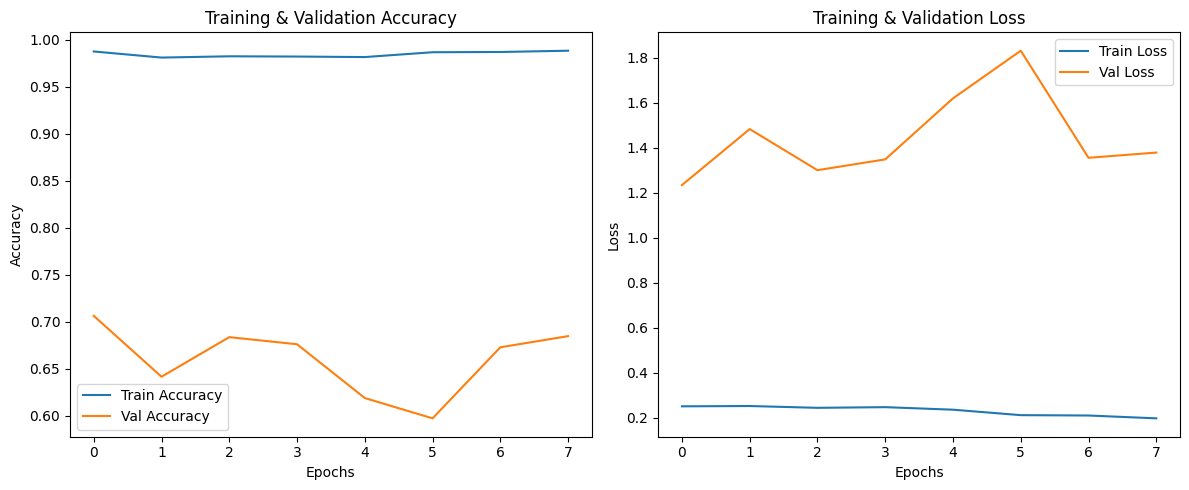

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step


<Figure size 800x600 with 0 Axes>

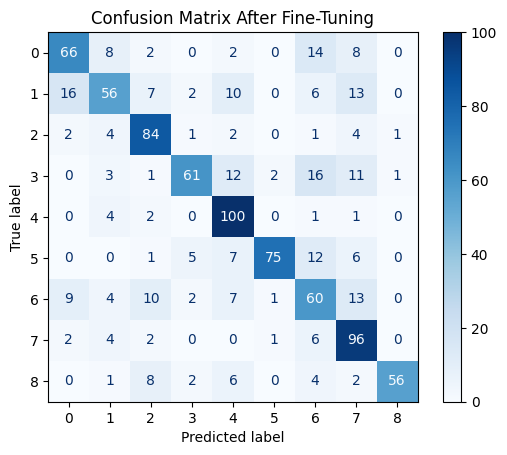

Test Accuracy After Fine-Tuning: 0.7063


In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === Unfreeze all layers ===
conv_base.trainable = True

# === Re-compile model with lower learning rate ===
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Define callbacks ===
callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='max', min_lr=1e-4),
    EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, restore_best_weights=True)
]

# === Fine-tuning the model ===
history_finetune = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

# === Plot training and validation accuracy/loss ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# === Predict and evaluate on test data ===
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # if y_test is one-hot encoded

# === Compute and display confusion matrix ===
cm = confusion_matrix(y_true, y_pred)
labels = [str(i) for i in range(cm.shape[0])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix After Fine-Tuning")
plt.show()

# === Print final test accuracy ===
final_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy After Fine-Tuning: {final_acc:.4f}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


<Figure size 800x600 with 0 Axes>

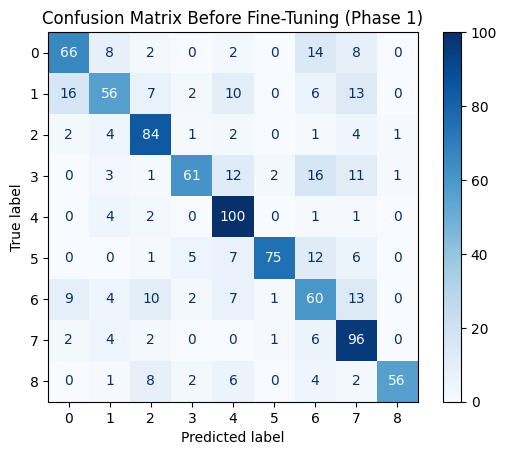

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict before fine-tuning (immediately after Phase 1)
y_pred_probs_phase1 = model.predict(x_test)
y_pred_phase1 = np.argmax(y_pred_probs_phase1, axis=1)
y_true = np.argmax(y_test, axis=1)  # assuming one-hot encoded labels

# Compute confusion matrix
cm_phase1 = confusion_matrix(y_true, y_pred_phase1)

# Display confusion matrix
labels = [str(i) for i in range(cm_phase1.shape[0])]  # or use class_names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm_phase1, display_labels=labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix Before Fine-Tuning (Phase 1)")
plt.show()
